In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
# data 
import numpy as np
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Prep Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                if(isinstance(val1,dict)) : 
                    print('\t',key1,end='')
                    for key2,val2 in val1.items():
                        print('\t\t',key2,'\t',len(val2))
                else : 
                    print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=472). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=663). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1717). ']
RED 	 472
GRN 	 663
BLU 	 1717


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
GRN	 ID 	 663
	 z 	 663
BLU	 ID 	 1717
	 z 	 1717


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

In [7]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns


# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
print('.', end='')

using210=True
if(using210):
    Lx_data16 = np.array(data16['Lx_210']) # x-ray luminosity in the 2-10 KeV band
    print('.', end='')
    kx_data16 = np.array(data16['abs_corr_210'])  # absorbtion correction coefficient in the 0.5-10 KeV band
    print('.', end='')
else : 
    Lx_data16 = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
    print('.', end='')
    kx_data16 = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
    print('.', end='')


...

In [8]:
print(cols16)

ColDefs(
    name = 'id_x'; format = '9A'
    name = 'RA_x'; format = 'D'
    name = 'DEC_x'; format = 'D'
    name = 'DET_ML_F'; format = 'E'
    name = 'DET_ML_S'; format = 'E'
    name = 'DET_ML_H'; format = 'E'
    name = 'flux_F'; format = 'E'
    name = 'flux_S'; format = 'E'
    name = 'flux_H'; format = 'E'
    name = 'HR'; format = 'E'
    name = 'HR_lo_lim'; format = 'E'
    name = 'HR_up_lim'; format = 'E'
    name = 'id_i'; format = 'J'; null = -2147483648
    name = 'ra_i'; format = 'D'
    name = 'dec_i'; format = 'D'
    name = 'i_mag'; format = 'E'
    name = 'i_mag_err'; format = 'E'
    name = 'flag_i_mag'; format = 'I'; null = -32768
    name = 'id_k_uv'; format = 'J'; null = -2147483648
    name = 'ra_k_uv'; format = 'D'
    name = 'dec_k_uv'; format = 'D'
    name = 'k_uv_mag'; format = 'E'
    name = 'k_uv_mag_err'; format = 'E'
    name = 'id_k_cfht'; format = 'J'; null = -2147483648
    name = 'ra_k_cfht'; format = 'D'
    name = 'dec_k_cfht'; format = 'D'
    n

In [9]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [10]:
# interpolates the luminosity at 1um
def Lum_at6um(lamFlam,lam,z) :
    lum_list = []
    for x,y,z in zip(lam,lamFlam,z) : 
        # interpolate
        f = SED.Interpolate_log(x,y)
        # normalize at 1um
        Fnu_at1um = SED.Flog_X(f,6*1E+4) # 6A * 10^4 = 6um
        # convert to luminosity
        lum_list.append(SED.Flux_to_Lum(Fnu_at1um,z))
    return(np.array(lum_list))

In [11]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    # get luminosity at 1um
    lum6um = np.log10( Lum_at6um(lamFlam, lamR, val['z'], ) )
    # append info
    # val['Rest Wavelength'] = lamR
    # val['Energy Density'] = lamFlam
    val['L(6um)'] = lum6um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 472
	 z 	 472
	 L(6um) 	 472
GRN	 ID 	 663
	 z 	 663
	 L(6um) 	 663
BLU	 ID 	 1717
	 z 	 1717
	 L(6um) 	 1717


In [12]:
agnInfo_yX = {}
agnInfo_nX = {}
for colorKey,agnValDict in agnInfo.items():
    ### get AGN with a good Lx
    # get key to the IDs from C-COSMOS data, which are parallel to Xray data
    key_agnID, key_id = match.match(agnValDict['ID'], id_data16)
    # get xray luminosity data
    Lx_agn = adp.IntrinsicLuminosity(Lx_data16[key_id], kx_data16[key_id])
    mask_Lx_agn_good = Lx_agn > 0
    # build 'yes Xray' dict 
    agnDict_yX = {}
    for dictKey, dictVal in agnValDict.items() : 
        agnDict_yX[dictKey] = dictVal[(key_agnID[mask_Lx_agn_good])]
    agnDict_yX['Lx'] = Lx_agn[mask_Lx_agn_good]
    ### get remaining AGN
    # match all agn to those with Lx
    key_fullLx, key_Lx = match.match(agnValDict['ID'], agnDict_yX['ID'])
    # get AGN without Lx
    mask_noLx = np.ones(agnValDict['ID'].shape, dtype=bool)
    mask_noLx[key_fullLx] = False 
    # build 'no Xray' dict 
    agnDict_nX = {}
    for dictKey, dictVal in agnValDict.items() : 
        agnDict_nX[dictKey] = dictVal[(mask_noLx)]
    ### finish
    agnInfo_yX[colorKey] = agnDict_yX
    agnInfo_nX[colorKey] = agnDict_nX

# verify number of sources
print('~~~~ yX ~~~~~')
PrintNumber(agnInfo_yX)
print('~~~~ nX ~~~~~')
PrintNumber(agnInfo_nX) # only RED should have nX

~~~~ yX ~~~~~
RED	 ID 	 17
	 z 	 17
	 L(6um) 	 17
	 Lx 	 17
GRN	 ID 	 587
	 z 	 587
	 L(6um) 	 587
	 Lx 	 587
BLU	 ID 	 1369
	 z 	 1369
	 L(6um) 	 1369
	 Lx 	 1369
~~~~ nX ~~~~~
RED	 ID 	 455
	 z 	 455
	 L(6um) 	 455
GRN	 ID 	 76
	 z 	 76
	 L(6um) 	 76
BLU	 ID 	 348
	 z 	 348
	 L(6um) 	 348


In [13]:
# returns array of ( min <= z < max )
def GetMaskFromRedshiftsInRange(
        zArr,    # np array of z  
        min=0,   # minimum
        max=99,  # maximum 
        incusiveMin=False,
) : 
    # get mask of indecies that are in redshift range (true)
    if(incusiveMin):
        return (zArr >= min) & (zArr < max)
    else: 
        return (zArr >  min) & (zArr <= max)

In [14]:
def GetAGNinZrange(agnInfo_Xx : dict[str,dict[str,np.array]]):
    agnInfo_xX_byZ = {}
    for colorKey,agnDict in agnInfo_Xx.items() : 
        agnInfo_xX_byZ[colorKey] = {}
        # get masks for each redshift bin 
        zArray = agnDict['z']
        zMasks = {
            '$0 < z \leq 1$'   : GetMaskFromRedshiftsInRange(zArray,          max=1  ),
            '$1 < z \leq 1.5$' : GetMaskFromRedshiftsInRange(zArray, min=1,   max=1.5),
            '$1.5 < z \leq 2$' : GetMaskFromRedshiftsInRange(zArray, min=1.5, max=2  ),
            '$2 < z \leq 3$'   : GetMaskFromRedshiftsInRange(zArray, min=2,   max=3  ),
            '$3 < z \leq 6$'   : GetMaskFromRedshiftsInRange(zArray, min=3           )
        }
        for zKey, zArr in zMasks.items() : 
            agnInfo_xX_byZ[colorKey][zKey] = {}
            for agnDictKey, agnDictVal in agnDict.items() : 
                agnInfo_xX_byZ[colorKey][zKey][agnDictKey] = agnDictVal[zArr]
    return agnInfo_xX_byZ

agnInfo_yX_byZ = GetAGNinZrange(agnInfo_yX)
agnInfo_nX_byZ = GetAGNinZrange(agnInfo_nX)

# verify number of sources
print('~~~~ yX ~~~~~')
PrintNumber(agnInfo_yX_byZ)
print('~~~~ nX ~~~~~')
PrintNumber(agnInfo_nX_byZ) # only RED should have nX

~~~~ yX ~~~~~
RED	 $0 < z \leq 1$		 ID 	 17
		 z 	 17
		 L(6um) 	 17
		 Lx 	 17
	 $1 < z \leq 1.5$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
	 $1.5 < z \leq 2$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
	 $2 < z \leq 3$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
	 $3 < z \leq 6$		 ID 	 0
		 z 	 0
		 L(6um) 	 0
		 Lx 	 0
GRN	 $0 < z \leq 1$		 ID 	 99
		 z 	 99
		 L(6um) 	 99
		 Lx 	 99
	 $1 < z \leq 1.5$		 ID 	 141
		 z 	 141
		 L(6um) 	 141
		 Lx 	 141
	 $1.5 < z \leq 2$		 ID 	 143
		 z 	 143
		 L(6um) 	 143
		 Lx 	 143
	 $2 < z \leq 3$		 ID 	 170
		 z 	 170
		 L(6um) 	 170
		 Lx 	 170
	 $3 < z \leq 6$		 ID 	 34
		 z 	 34
		 L(6um) 	 34
		 Lx 	 34
BLU	 $0 < z \leq 1$		 ID 	 358
		 z 	 358
		 L(6um) 	 358
		 Lx 	 358
	 $1 < z \leq 1.5$		 ID 	 435
		 z 	 435
		 L(6um) 	 435
		 Lx 	 435
	 $1.5 < z \leq 2$		 ID 	 288
		 z 	 288
		 L(6um) 	 288
		 Lx 	 288
	 $2 < z \leq 3$		 ID 	 252
		 z 	 252
		 L(6um) 	 252
		 Lx 	 252
	 $3 < z \leq 6$		 ID 	 36
		 z 	 36
		 L(6um) 	 36
		 Lx 	 36
~~~~ nX 

# Plot

In [15]:
def DrawSternLine(ax, xmin=40, xmax=50, using210=True) : 
    # y = 40.981 + 1.024x - 0.047x^2
    #   where: 
    #       y = log (Lx) 
    #       x = log (L(6um) / 1e41) = log (L(6um)) - 41
    x = np.linspace(xmin, xmax, 100)
    y = (40.981 + ( 1.024 * (x - 41) ) - ( 0.047 * ((x - 41) ** 2) ))
    if(not using210):
        #   y = log (Lx * 1.64) = log (Lx) + log( 1.64 ) 
        y = y + np.log10(1.64)
    ax.plot(x,y, c='k')

    # .5-10 <-- 2-10 should increace 

In [16]:
def PlotTricolor_ax(
    ax,
    x_red, y_red, # x = L(6um), y = Lx
    x_grn, y_grn,
    x_blu, y_blu,
    fullText='',
    using210=True
) :
    # plot data
    ax.scatter(x_blu, y_blu, marker='s', c=adp.c_xray,     s=2, label='Exclusive X-ray (n='+str(len(x_blu))+')')
    ax.scatter(x_red, y_red, marker='^', c=adp.c_ir,       s=2, label='Exclusive MIR (n='+  str(len(x_red))+')')
    ax.scatter(x_grn, y_grn, marker='o', c=adp.c_ir_xray,  s=2, label='Inclusive (n='+      str(len(x_grn))+')')
    DrawSternLine(ax, using210=using210)
    adp.PlotContours_ax( ax, np.concatenate([x_blu,x_red,x_grn]), np.concatenate([y_blu,y_red,y_grn]) )
    # decorations
    adp.AddText_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    if(fullText != '') : adp.AddText_z_ax(ax, fullText)
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([41.5,48.5])
    ax.set_ylim([41.5,46])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

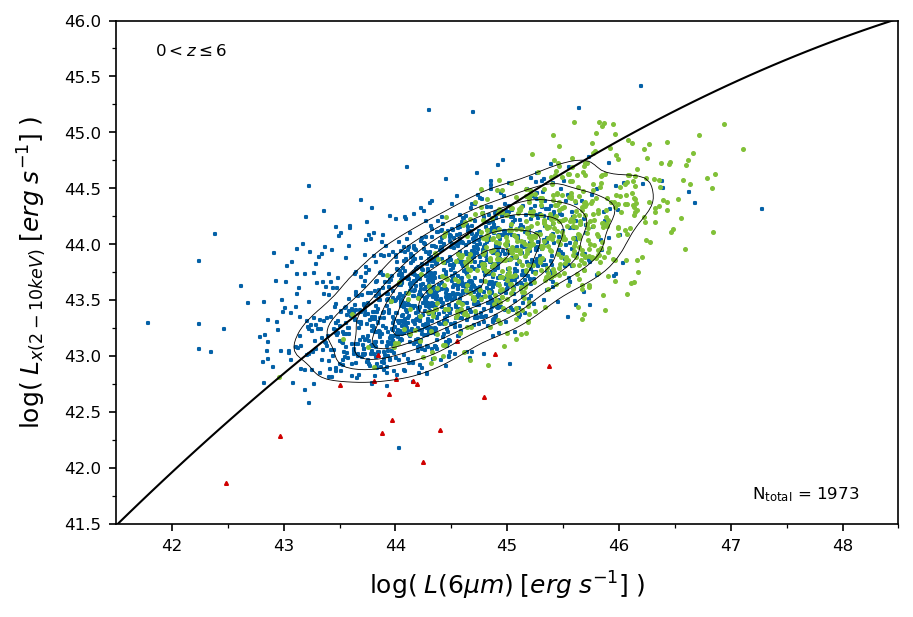

In [17]:
def PlotStern2015(
    agnInfo_yX,
    save = None,
    using210 = True
) :
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')

    PlotTricolor_ax(
        ax=ax,
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$',
        using210 = using210
    )

    # lables 
    if(using210):
        plt.ylabel('$\log( \; L_{x(2-10keV)} \; [erg \; s^{-1}] \;)$')
    else : 
        plt.ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    plt.xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

PlotStern2015(agnInfo_yX,
              save=adp.path_fig + '\\v2_LxVsL6um_zAll.png')

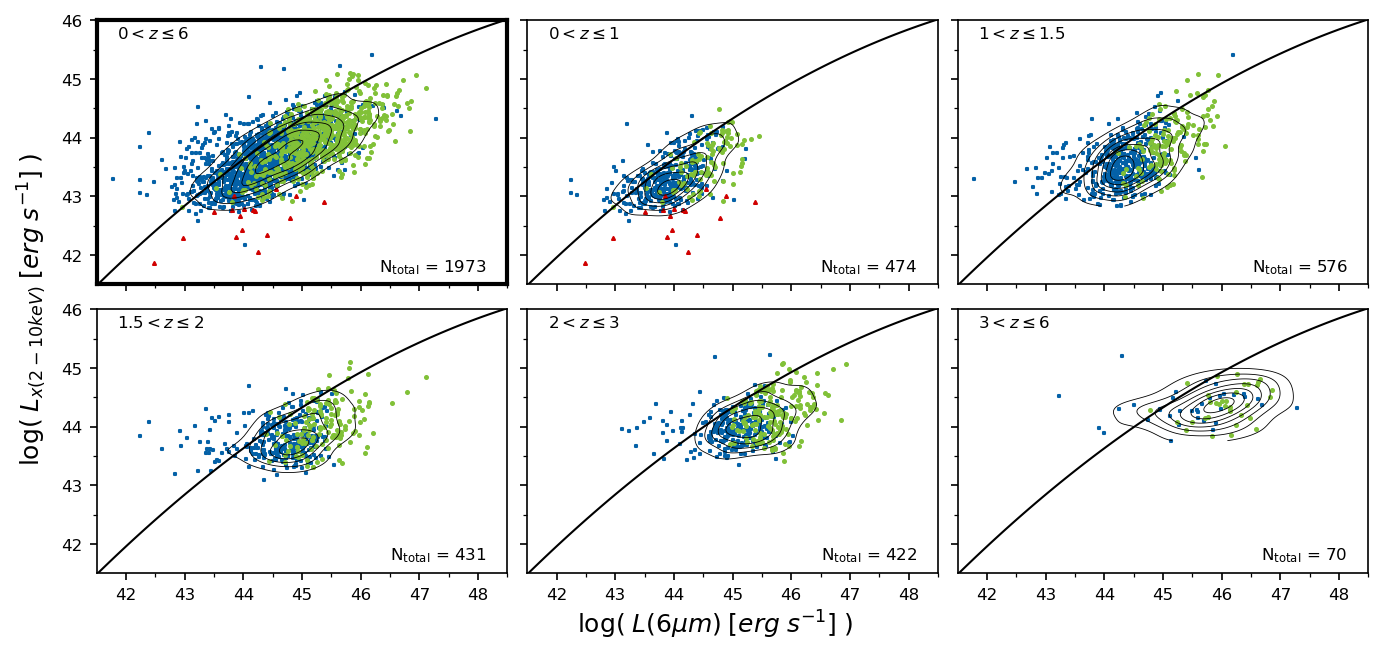

In [18]:
def PlotStern2015_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save = None,
    using210 = True
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)
    fig.set_figheight((2*2))    
    fig.set_figwidth((3*3)-0.2)   

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotTricolor_ax(
        ax=ax[0][0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$',
        using210 = using210
    )

    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotTricolor_ax(
            ax=ax[row][col],
            x_red = agnInfo_yX_byZ['RED'][zrange]['L(6um)'], 
            y_red = agnInfo_yX_byZ['RED'][zrange]['Lx'],
            x_grn = agnInfo_yX_byZ['GRN'][zrange]['L(6um)'], 
            y_grn = agnInfo_yX_byZ['GRN'][zrange]['Lx'],
            x_blu = agnInfo_yX_byZ['BLU'][zrange]['L(6um)'],  
            y_blu = agnInfo_yX_byZ['BLU'][zrange]['Lx'],
            fullText=zrange
        )
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
        plt.xlabel('')
    
    if(using210):
        adp.ByZ_FinishPlot(
            fig,
            '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
            '$\log( \; L_{x(2-10keV)} \; [erg \; s^{-1}] \;)$',
            save, (0.5, -0.04), (-0.03, 0.5)
        )
    else:
        adp.ByZ_FinishPlot(
            fig,
            '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
            '$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$',
            save, (0.5, -0.04), (-0.03, 0.5)
        )

PlotStern2015_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save=adp.path_fig + '\\v2_LxVsL6um_rect.png'
)

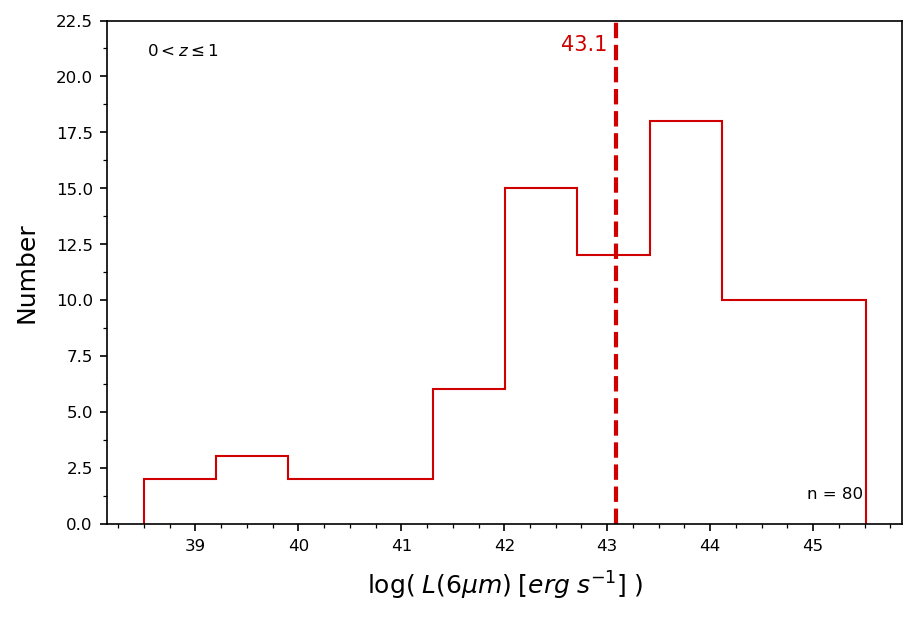

In [19]:
def ShowL6umForNX(agnInfo_nX_byZ, textN=True, save=None) : 
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')

    x = agnInfo_nX_byZ['RED']['$0 < z \leq 1$']['L(6um)'] # these are the only sources without Lx
    ax.hist(x, histtype='step', color=adp.c_ir)
    ax.set_ylim(ymin=0, ymax=22.5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if(textN) : adp.AddText_n_ax(ax,len(x))
    adp.MeanLineForHist_ax(ax=ax,x=x,c=adp.c_ir,xtext=0.998,ytext=0.94,horizAlign='right',pre='')
    adp.AddText_z_ax(ax, fullText='$0 < z \leq 1$')

    # lables 
    plt.xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

ShowL6umForNX(
    agnInfo_nX_byZ,
    save=adp.path_fig + '\\v2_L6um_noLx_hist.png'    
)